<a href="https://colab.research.google.com/github/Monoxido45/Graos_de_arroz_AM/blob/main/trabalho_2_graos_arroz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# pacotes para pegar os dados da net
from zipfile import ZipFile
from io import BytesIO
import urllib.request as urllib2

# pacotes importados
import numpy as np
import pandas as pd

# para os graficos
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import seaborn as sns

Montando o drive para armazenar as imagens e importar os dados:

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")
# path para salvar as figuras
images_dir = '/content/gdrive/MyDrive/AM_trabalhos/figuras'
#data_path = '/content/gdrive/MyDrive/AM_trabalhos/Rice_Osmancik_Cammeo_Dataset.xlsx'


Mounted at /content/gdrive


In [ ]:
# importando os dados
#rice_df = pd.read_excel(data_path)

link_do_arroz ='https://www.muratkoklu.com/datasets/vtdhnd03.php'
rice_df = pd.read_excel(link_do_arroz,'Rice_Osmancik_Cammeo_Dataset')
rice_df.head()

,AREA,PERIMETER,MAJORAXIS,MINORAXIS,ECCENTRICITY,CONVEX_AREA,EXTENT,CLASS
0,15231,525.578979,229.749878,85.093788,0.928882,15617,0.572896,Cammeo
1,14656,494.311005,206.020065,91.730972,0.895405,15072,0.615436,Cammeo
2,14634,501.122009,214.106781,87.768288,0.912118,14954,0.693259,Cammeo
3,13176,458.342987,193.337387,87.448395,0.891861,13368,0.640669,Cammeo
4,14688,507.166992,211.743378,89.312454,0.906691,15262,0.646024,Cammeo


Checando primeiramente cada objeto do banco de dados:

In [ ]:
rice_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3810 entries, 0 to 3809
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   AREA          3810 non-null   int64  
 1   PERIMETER     3810 non-null   float64
 2   MAJORAXIS     3810 non-null   float64
 3   MINORAXIS     3810 non-null   float64
 4   ECCENTRICITY  3810 non-null   float64
 5   CONVEX_AREA   3810 non-null   int64  
 6   EXTENT        3810 non-null   float64
 7   CLASS         3810 non-null   object 
dtypes: float64(5), int64(2), object(1)
memory usage: 238.2+ KB


Vemos então que todos os atributos com exceção da classe são numéricos. Elencamos cada variável a seguir:  

*   **Area**: Número de pixels dentro do grão de arroz na imagem
*   **Perimeter**: Circunferência calculada a partir da distância entre os pixels localizados ao redor da borda do grão de arroz
*   **Major Axis Length**: A maior linha que pode ser desenhada no grão de arroz
*   **Minor Axis Length**: A menor linha que pode ser desenhada no grão de arroz
*   **Eccentricity**: Quão redondo é a elipse do arroz
*   **Convex Area**: Retorna a contagem de pixels da menor conxa convexa pertencente a região do grão de arroz
*   **Extent**: Retorna a razão da região formada pelo grão de arroz com relação aos pixels dentro da borda da foto
*   **Class**: Tipos de arroz: Cammeo e Osmancik

A variável Class será considerada externa ao modelo, utilizada para medidas externa de clustering. Explorando inicialmente os 7 principais atributos temos:

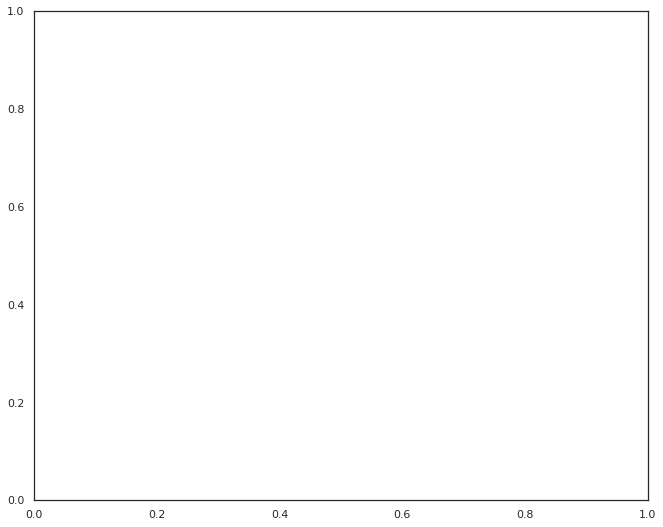

In [ ]:
rice_features = rice_df.drop("CLASS", axis = 1)
cor = rice_features.corr(method = 'spearman')

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(cor, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

Draw the heatmap with the mask and correct aspect ratio
sns.set_theme(style="white")
sns.heatmap(cor, mask=mask, cmap=cmap, vmax=1, center=0, vmin = -1,
           square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot = True)
plt.savefig(f"{images_dir}/figura_cluster/corr_matrix.pdf")
plt.show()

Vemos que a variável convex_area tem colinearidade grande com area, tendo correlação praticamente 1. Vemos que o Perimetro também tem altissima correlação com as ambas áreas. Isso não é problema aqui, pois queremos apenas analisar a estrutura dos dados a partir de agrupamentos. Podemos ver como se dá a distribuição entre cada variável a seguir:

<Figure size 576x432 with 0 Axes>

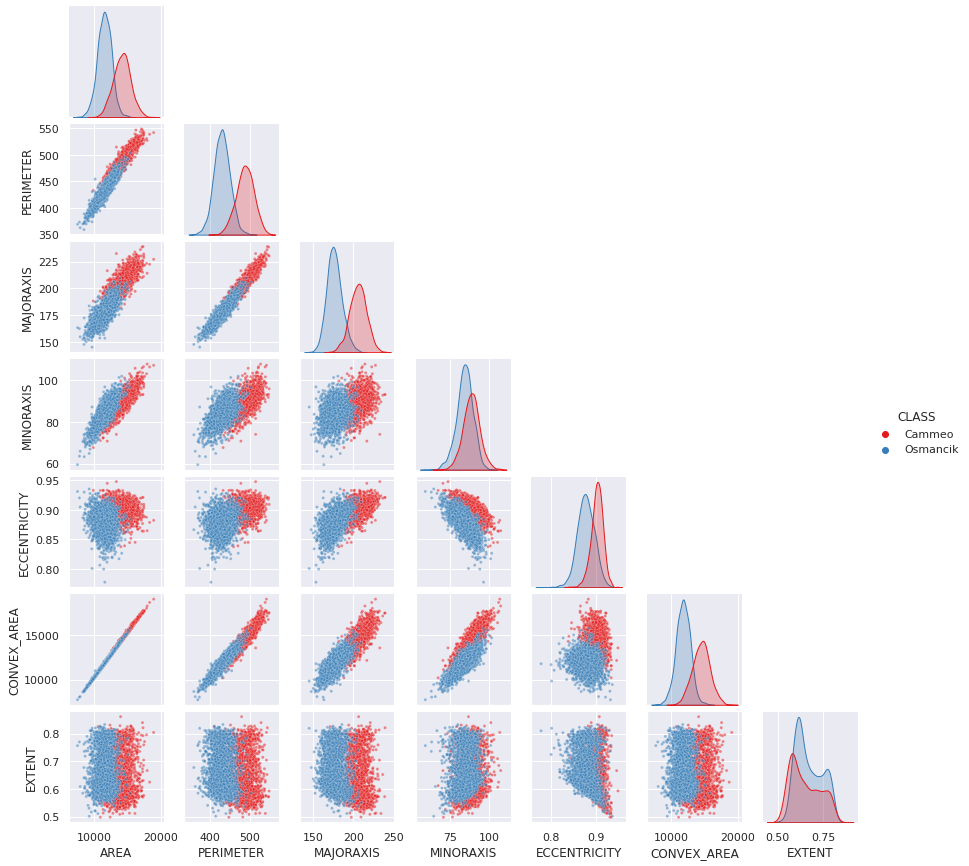

In [ ]:
# setando agora a palheta e a cor da grade
sns.set_style("darkgrid")

plt.figure(figsize = (8, 6))
sns.pairplot(rice_df, corner = True, hue = "CLASS", height = 1.75,
             plot_kws={'alpha': 0.5, 's':9}, palette = "Set1")
plt.savefig(f"{images_dir}/figura_cluster/pair_plot.pdf")
plt.show()

In [ ]:
rice_df['CLASS'].value_counts()

Osmancik    2180
Cammeo      1630
Name: CLASS, dtype: int64

<Figure size 576x432 with 0 Axes>

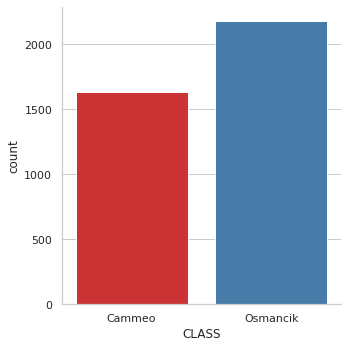

In [ ]:
# grafico de barras ilustrando
sns.set_style("whitegrid")
plt.figure(figsize = (8, 6))
sns.catplot(x="CLASS", kind="count", palette="Set1", data = rice_df)
plt.savefig(f"{images_dir}/figura_cluster/class_barplot.pdf")
plt.show()

Utilizaremos para avaliar cada clustering diferentes medidas de avaliação externas, internas e relativas. Utilizaremos o indice de rand ajustado (ARI) e a medida V (V-measure) como medidas que requerem ground truth. Para medidas de validação relativa, podemos usar a silhueta média, indice de Dunn (davies_bouldin) e indice de Calinz-Harabaz.

# Cluster Hierárquico

Consideraremos os métodos de cluster aglomerativo, tendo três principais ligações de interesse: single, average e complete, juntamente também com o método de ward para construir os diferentes dendrogramas. Assim, computamos o dendrograma para cada uma das ligações:

In [ ]:
# para plotar usaremos o scipy
from scipy.cluster.hierarchy import dendrogram, linkage
single = linkage(rice_features, 'single')

# listas dos tipos de linkages
link_methods = ['single', 'complete', 'average', 'ward']
clusters_dend = []

# escalonando os dados
from sklearn.preprocessing import StandardScaler
rice_standard = StandardScaler().fit_transform(rice_features)
for link in link_methods:
  clusters_dend.append(linkage(rice_standard, link))

Plotando os dendrogramas lado a lado:

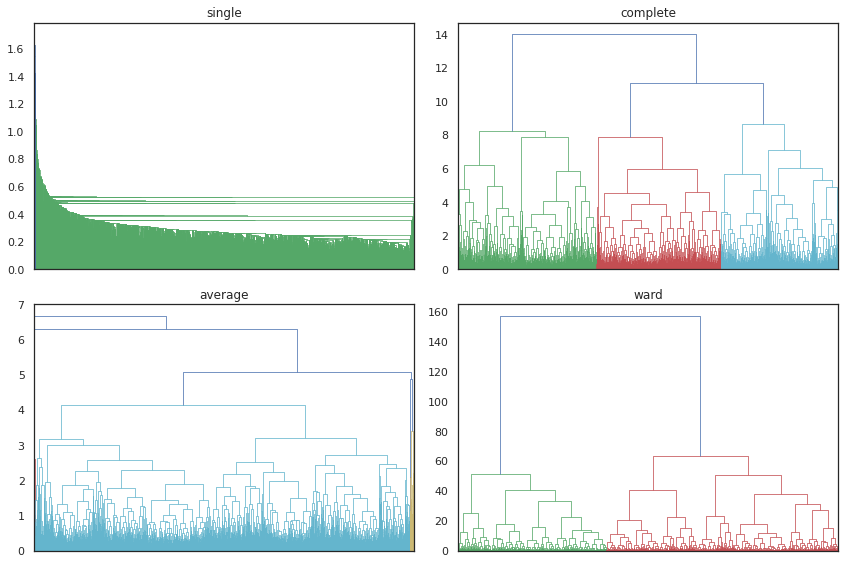

In [ ]:
fig, axes = plt.subplots(2, 2, figsize = (12, 8))
import sys
sys.setrecursionlimit(10000)
sns.set_style("whitegrid")
for dend, ax, link_name in zip(clusters_dend, axes.flat, link_methods):
  with plt.rc_context({'lines.linewidth': 0.75}):
    dendrogram(dend,
             orientation = 'top',
             distance_sort = 'descending',
             show_leaf_counts = False,
             no_labels = True,
             ax = ax)
    ax.set_title(link_name)
plt.tight_layout()
#plt.savefig(f"{images_dir}/figura_cluster/dendrogramas.pdf")

Vemos uma maior regularidade de dendrograma nas ligações average, ward e complete, tendo possivelmente sugestões de 4 grupos no average e 2 no ward e 3 no complete. Pela irregularidade do dendrograma single, o descartaremos logo de cara. Podemos a seguir avaliar por medidas externas os 3 métodos de cluster hierarquico:

In [ ]:
from sklearn.cluster import AgglomerativeClustering
# diferentes particoes fixadas
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
# dicionario para cada linkage
complete_dict, average_dict, ward_dict = dict(), dict(), dict()
for clust in range_n_clusters:
  complete_dict[clust] = AgglomerativeClustering(n_clusters = clust,
                                      linkage = 'complete').fit(rice_standard)
  average_dict[clust] = AgglomerativeClustering(n_clusters = clust,
                                      linkage = 'average').fit(rice_standard)
  ward_dict[clust] = AgglomerativeClustering(n_clusters = clust,
                                      linkage = 'ward').fit(rice_standard)

Atribuindo mesmo peso para homogeneidade e completeza na V-measure

In [ ]:
# ajustando o indice de rand ajustado e v-measure
from sklearn.metrics import adjusted_rand_score, v_measure_score
ARI_list, V_measure = [], []

# ground truth
label_true = (rice_df['CLASS'] == "Cammeo").astype(int).values
# predicao do label para cada clustering
for method in [complete_dict[2], average_dict[2], ward_dict[2]]:
  ARI_list.append(adjusted_rand_score(label_true,
                                      method.labels_))
  V_measure.append(v_measure_score(label_true,
                                   method.labels_))

Assim, em uma tabela, obtemos:

In [ ]:
extern_measures = pd.DataFrame(data = {'linkages':["complete", "average", "ward"],
                                       'ARI':ARI_list,
                                       'V_measure':V_measure})
extern_measures

,linkages,ARI,V_measure
0,complete,0.321393,0.240527
1,average,-0.000264,0.000853
2,ward,0.622834,0.514483


Vemos pelos scores que o average e ward tem bons scores internos em comparação ao complete. A seguir podemos ainda fazer scores relativos, variando os diversos k:

In [ ]:
from sklearn.metrics import (silhouette_score, silhouette_samples, 
                            calinski_harabasz_score, davies_bouldin_score)
# lista para as medidas
silhouette_list, chs_list, dunn_list = [], [], []
# lista para nomes e k
names_list, k_list = [], []
for k in range_n_clusters:
  # silhueta
  sil_complete = silhouette_score(rice_features, complete_dict[k].labels_, 
                                  random_state = 25)
  sil_average = silhouette_score(rice_features, average_dict[k].labels_, 
                                  random_state = 25)
  sil_ward = silhouette_score(rice_features, ward_dict[k].labels_, 
                                  random_state = 25)
  sil_complete = silhouette_score(rice_features, complete_dict[k].labels_, 
                                  random_state = 25)
  # calinski_harabasz
  chs_average = calinski_harabasz_score(rice_features, average_dict[k].labels_)
  chs_ward = calinski_harabasz_score(rice_features, ward_dict[k].labels_)
  chs_complete = calinski_harabasz_score(rice_features, 
                                         complete_dict[k].labels_)
  
  # davies_bouldin
  dunn_average = davies_bouldin_score(rice_features, average_dict[k].labels_)
  dunn_ward = davies_bouldin_score(rice_features, ward_dict[k].labels_)
  dunn_complete = davies_bouldin_score(rice_features, 
                                         complete_dict[k].labels_)
  # adicionando a todas as listas
  silhouette_list.extend([sil_complete, sil_average,
                         sil_ward])
  chs_list.extend([chs_complete, chs_average,
                         chs_ward])
  dunn_list.extend([dunn_complete, dunn_average,
                         dunn_ward])
  # nomes dos metodos e k usado
  names_list.extend(["complete", "average", "ward"])
  k_list.extend(list(np.repeat(k, 3)))

Formatando como data frame para depois plotar tudo:

In [ ]:
hclust_measures = pd.DataFrame(data = {'linkages':names_list,
                                       'k':k_list,
                                       'silhueta':silhouette_list,
                                       'chs':chs_list,
                                       'dunn':dunn_list})
hclust_measures.head()

,linkages,k,silhueta,chs,dunn
0,complete,2,0.490927,5734.970882,0.630025
1,average,2,0.027284,2.777594,1.166943
2,ward,2,0.557922,7432.327969,0.566359
3,complete,3,0.200331,2867.351701,36.886721
4,average,3,-0.066067,31.000810,0.912427


FileNotFoundError: ignored

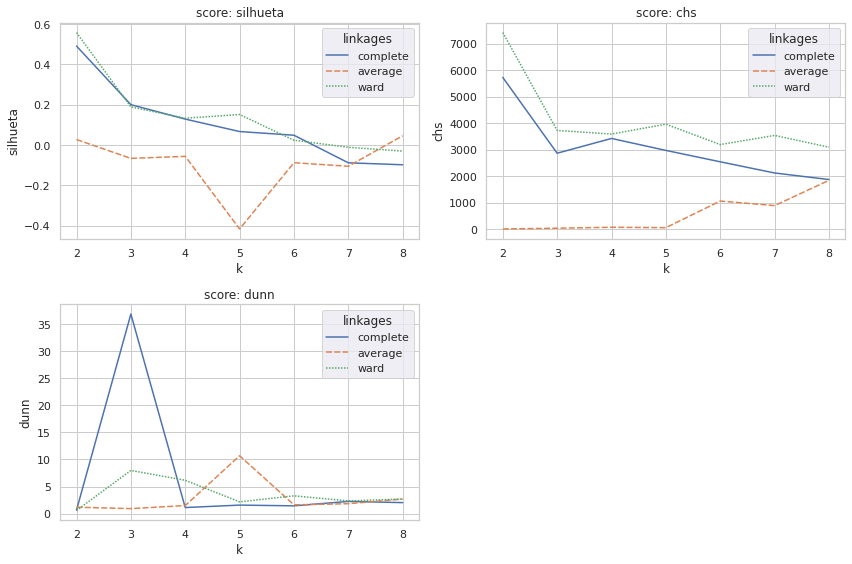

In [ ]:
# plotando os diferentes k's
fig, axes = plt.subplots(2, 2, figsize = (12, 8))
sns.set_style("darkgrid")
for ax, score in zip(axes.flat, ["silhueta", "chs", "dunn"]):
  sns.lineplot(data = hclust_measures,
               x = "k", y = score, ax = ax,
               hue = "linkages", style = "linkages")
  ax.set_title("score: {}".format(score))
fig.delaxes(axes[1][1])
plt.tight_layout()
plt.savefig(f"{images_dir}/figura_cluster/scores_relativos_hclust.pdf")
plt.show()

# K-means

Pelo método do cotovelo, ajustaremos vários K-means, com o número de clusters indo de 1 a 10. Após isso, calcularemos a distorção para cada modelo.

In [ ]:
from sklearn.cluster import KMeans

distortions = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k, random_state=25)
    km.fit(rice_standard)
    distortions.append(km.inertia_)


Plotando as diferentes distorções por cada valor de k:

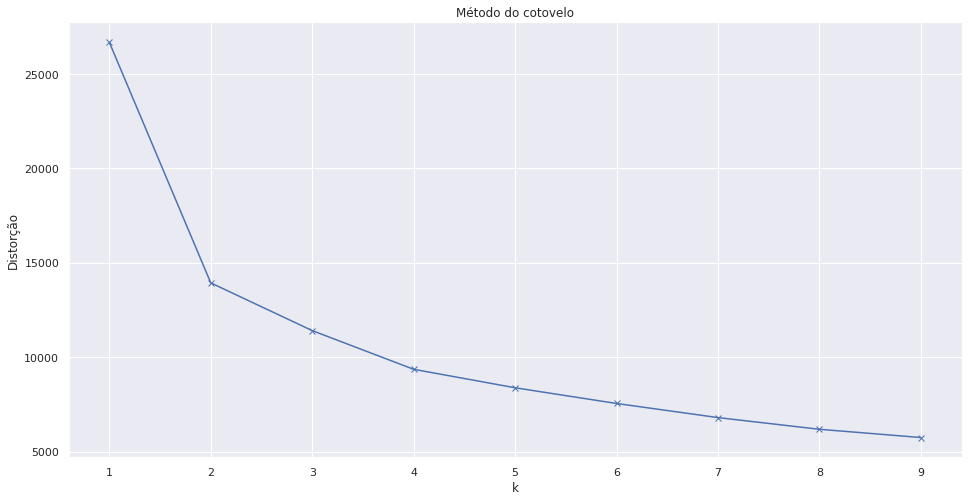

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distorção')
plt.title('Método do cotovelo')
plt.show()

Portanto, vemos que o número ótimo de clusters é k = 4, embora o ponto de inflexão no gráfico não seja tão acentuado. Sendo assim, ajustaremos um modelo K-means com n_clusters = 4.

In [ ]:
km = KMeans(n_clusters=4, random_state=25)
km.fit(rice_standard)

KMeans(n_clusters=4, random_state=25)

In [ ]:
ARI = adjusted_rand_score(label_true, km.labels_)
V_measure = v_measure_score(label_true, km.labels_)

# Dbscan

In [ ]:
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN 
from sklearn.metrics import (silhouette_score, silhouette_samples, 
                             calinski_harabasz_score, davies_bouldin_score,
                             adjusted_rand_score, v_measure_score)



link_do_arroz ='https://www.muratkoklu.com/datasets/vtdhnd03.php'
rice_df = pd.read_excel(link_do_arroz,'Rice_Osmancik_Cammeo_Dataset')
rice_features = rice_df.drop("CLASS", axis = 1)

### Normalizando os dados
rice_standard = StandardScaler().fit_transform(rice_features)

Para o número mínimo de observações ($minPts$), será considerado um $2*dim$, em que $dim$ é o número de colunas/variáveis. Tal sugestão é encontrada em [(Sander et al., 1998)](https://stackoverflow.com/a/54115075)


In [ ]:
print("O número mínimo de pontos na vizinha para considerar um p como ponto é: {}".format(2*rice_standard.shape[1]))

O número mínimo de pontos na vizinha para considerar um p como ponto é: 14


Escolhido o número mínimo de pontos na vizinha, fixa-se ele e busca-se encontrar o valor de $ϵ$ (distância máxima da vizinhança). Para isso se faz um gráfico da distância do k-vizinho mais próximo contra os pontos ordenados de forma crescente pela própria distância. Nesse kaso, k=($minPts$) já escolhido anteriormente. Essa sugestão também é encontrada em [(Sander et al., 1998)](https://stackoverflow.com/a/54115075)

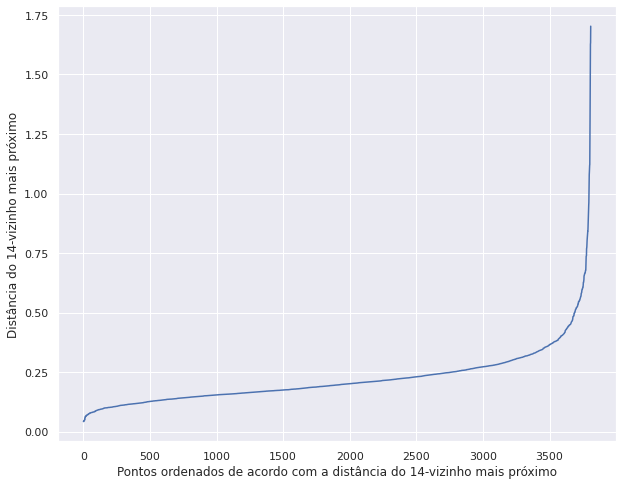

In [ ]:
### Definindo o k de k-vizinho 
vizinhos = NearestNeighbors(n_neighbors=2*rice_standard.shape[1],
                            p=2,metric='minkowski')

## Lembrando que p=2 e metric='minkowski'
# equivale a distancia euclidicana.

### Encontrado as distancias para o banco de dados
vizinhos_ajuste = vizinhos.fit(rice_standard)
dist, indi = vizinhos_ajuste.kneighbors(rice_standard)
### Ordenando os pontos
dist = np.sort(dist, axis=0)
dist = dist[:,1]

### Plotando o grafico 
sns.set_style("darkgrid")
plt.figure(figsize = (10, 8))
plt.plot(dist)
plt.xlabel("Pontos ordenados de acordo com a distância do {}-vizinho mais próximo".format(2*rice_standard.shape[1]))
plt.ylabel("Distância do {}-vizinho mais próximo".format(2*rice_standard.shape[1]))
#plt.savefig(f"{images_dir}/figura_cluster/dbscan_cotovelo_14_vizinhos.pdf")
plt.show()


Observando o Figura anterior, percebe-se que a distância ideal ser considerar é em torno de 0.4, onde está o cotovelo do gráfico.

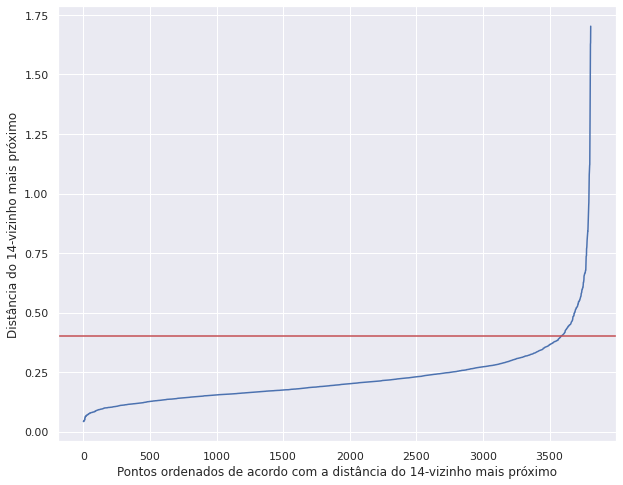

In [ ]:
### Plotando o grafico 
sns.set_style("darkgrid")
plt.figure(figsize = (10, 8))
plt.plot(dist)
plt.axhline(y = 0.4, color = 'r', linestyle = '-')
plt.xlabel("Pontos ordenados de acordo com a distância do {}-vizinho mais próximo".format(2*rice_standard.shape[1]))
plt.ylabel("Distância do {}-vizinho mais próximo".format(2*rice_standard.shape[1]))
#plt.savefig(f"{images_dir}/figura_cluster/dbscan_cotovelo_14_vizinhos.pdf")
plt.show()

In [ ]:
print("O minPts do dbscan é {}.".format(2*rice_standard.shape[1]))
print("A distância epsilon do dbscan é {}.".format(0.4))

O minPts do dbscan é 14.
A distância epsilon do dbscan é 0.4.


Encontrado os hiperparâmetros, basta ajustar o DBScan.

In [ ]:
### Ajustando o DBScan
dbscan_rice = DBSCAN(min_samples=2*rice_standard.shape[1],eps=0.4).fit(rice_standard)

# Verdadeiro rotulo
label_true = (rice_df['CLASS'] == "Cammeo").astype(int).values

# Rotulo do dbscan
modifica_rotulo_dbs = np.zeros_like(dbscan_rice.labels_, dtype=bool)
modifica_rotulo_dbs[dbscan_rice.core_sample_indices_] = True
label_dbscan = dbscan_rice.labels_

# Numero de cluseters e de ruidos (se presente)
n_clusters_dbscan = len(set(label_dbscan)) - (1 if -1 in label_dbscan else 0)
n_noise_dbscan = list(label_dbscan).count(-1)

print('Número de cluters no DBSCan: {}'.format(n_clusters_dbscan))
print('Número de ruídos no DBSCan: {}'.format(n_noise_dbscan))

Número de cluters no DBSCan: 9
Número de ruídos no DBSCan: 1778


Nota-se que o DBScan deixou muitas observações de fora de clusters. Além de encontrar 9 cluters, um número alto uma vez que há somente 2 tipos de arroz.

#### DBScan - Críterios externos


In [ ]:
print('V-measure do DBSCan: {}'.format(v_measure_score(label_true,label_dbscan)))
print('Rand Index Ajustado do DBSCan: {}'.format(adjusted_rand_score(label_true,label_dbscan)))

V-measure do DBSCan: 0.03978907830723931
Rand Index Ajustado do DBSCan: 0.040828656631089075


Nota-se que o Rand Index Ajustado está muito baixo, mostrando que o DBSCan não se saiu bem. Já o V-measure ficou relativamente baixo.

**(pode juntar?)**

In [ ]:
### Juntando com as medidas anteriores
'''
extern_measures = pd.concat([extern_measures,
                             pd.DataFrame(data= {'linkages':["DBSCan"],
        'ARI':[adjusted_rand_score(label_true,label_dbscan)],
        'V_measure':[v_measure_score(label_true,label_dbscan)]})])

extern_measures
'''

#### DBScan - Críterios relativos

$\quad$ Dado que o DBSCan utiliza-se do conceito de densidade para criar os clusters, o conceito de ruído também está presente, isto é, há pontos que não pertencem em nenhuma classificação. 

$\quad$ Desse modo, utiliza-se um critério especial para técnicas de agrupamentos baseado em densidade, que é o [CDbw](https://sci-hub.se/10.1016/j.patrec.2007.12.011) (density-based cluster validity approach using multi-representatives). Quanto maior essa medida, melhor.

In [ ]:
!pip install cdbw
from cdbw import CDbw

In [ ]:
print("O CBbw do DBSCan é {}".format(CDbw(rice_standard,label_dbscan, metric="euclidean",alg_noise="filter")))

O CBbw do DBSCan é 0.05445788667846365


Mesmo não sendo totalmente correto, calcula-se as outras medidas relativas para o DBSCan.

In [ ]:
print("A Silhueta média do DBSCan é {}".format(silhouette_score(rice_standard,label_dbscan,random_state=25)))
print("O Davies Bouldin Score do DBSCan é {}".format(davies_bouldin_score(rice_standard,label_dbscan)))
print("O Calinski harabasz score do DBSCan é {}".format(calinski_harabasz_score(rice_standard,label_dbscan)))

A Silhueta média do DBSCan é -0.39577180079379254
O Davies Bouldin Score do DBSCan é 2.779416619847157
O Calinski harabasz score do DBSCan é 26.653625554057065


#### DBScan - Otimização com critério relativo

Dado que os valores obtidos para o DBScan não foram bons, busca-se otimizar a medida relativa Davies Bouldin Score para encontra melhores hiperparâmetros $minPts$ e $ϵ$. Tal otimização será feita com otimização bayesiana.

In [ ]:
!pip install bayesian-optimization
from bayes_opt import BayesianOptimization

In [ ]:
def fun_DBSCan_para_tunar_relativo(min_samples,eps):

  # Ajusta-se o DBScan dado os argumentos de entrada
  dbscan_atual = DBSCAN(min_samples=int(min_samples),eps=eps).fit(rice_standard)

  # Obtem-se os rotulos 
  modifica_rotulo_dbs_atual = np.zeros_like(dbscan_atual.labels_, dtype=bool)
  modifica_rotulo_dbs_atual[dbscan_atual.core_sample_indices_] = True
  label_dbscan_atual = dbscan_atual.labels_


  ### No davies_bouldin_score, menor melhor, ateh um valor maximo de 0.
  ### Entao, busca-se maximizar o oposto (vezes -1) dele. 
  return(-1*davies_bouldin_score(rice_standard,label_dbscan_atual))

Os valores percorridos de $min\_sample$ do DBSCan serão de 7 a 14 e o $ϵ$ é de 0.25 a 0.75.

In [ ]:
### Limites inferiores e superioes dos 
## hiperparametros que serao explorados.

limites_dbscan = {'min_samples':(7,14),'eps':(0.25,0.75)}

### Escrita do Otimizador
dbscan_bo_relativo = BayesianOptimization(f=fun_DBSCan_para_tunar_relativo,
                                          pbounds=limites_dbscan,
                                          random_state=5,verbose=1)

### No local, demorou 35s
dbscan_bo_relativo_max = dbscan_bo_relativo.maximize(n_iter=50,init_points=20,acq='ei')

|   iter    |  target   |    eps    | min_sa... |
-------------------------------------------------
|  6        | -1.597    |  0.2904   |  12.17    |
|  14       | -1.416    |  0.3328   |  13.75    |
|  22       | -1.379    |  0.259    |  7.695    |
|  56       | -1.377    |  0.278    |  9.319    |


In [ ]:
print("Após a tunagem com medida relativa, o número mínimo de pontos foi de {}.".format( int(dbscan_bo_relativo.max['params']['min_samples']) ) )
print("Após a tunagem com medida relativa, a distância da vizinha foi de {}.".format( dbscan_bo_relativo.max['params']['eps'] )) 

Após a tunagem com medida relativa, o número mínimo de pontos foi de 9.
Após a tunagem com medida relativa, a distância da vizinha foi de 0.27800812280367454.


In [ ]:
### Ajustando o DBScan
dbscan_rice_2= DBSCAN(min_samples= int(dbscan_bo_relativo.max['params']['min_samples']),
                                 eps=dbscan_bo_relativo.max['params']['eps']).fit(rice_standard)

# Verdadeiro rotulo
label_true = (rice_df['CLASS'] == "Cammeo").astype(int).values
 
# Rotulo do dbscan
modifica_rotulo_dbs_2 = np.zeros_like(dbscan_rice_2.labels_, dtype=bool)
modifica_rotulo_dbs_2[dbscan_rice_2.core_sample_indices_] = True
label_dbscan_2 = dbscan_rice_2.labels_

# Numero de cluseters e de ruidos (se presente)
n_clusters_dbscan_2 = len(set(label_dbscan_2)) - (1 if -1 in label_dbscan_2 else 0)
n_noise_dbscan_2 = list(label_dbscan_2).count(-1)

print('Número de cluters no DBSCan: {}'.format(n_clusters_dbscan_2))
print('Número de ruídos no DBSCan: {}'.format(n_noise_dbscan_2))

Número de cluters no DBSCan: 19
Número de ruídos no DBSCan: 2908


$\quad$ Mesmo após a otimização Bayesiana, o processo de agrupamento pelo DBScan ficou pior, encontrando 19 clusters (muitos grupos, dado que são 2 tipos de arroz), com uma enorme quantidade de ruídos.

$\quad$ Provavelmente a escolha da medida de Davies Bouldin Score não foi boa para lidar com os ruídos. O ideal seria escolher uma medida própria que lida com a densidade, como o [CDbw](https://sci-hub.se/10.1016/j.patrec.2007.12.011) ou o [DBCV](https://sci-hub.se/10.1137/1.9781611973440.96), porém devido ao alto tempo de execução delas, as mesmas foram descartadas no uso da otimização.

#### DBSCan após otimização - Medidas Externas

In [ ]:
print('Após otimização, V-measure do DBSCan: {}'.format(v_measure_score(label_true,label_dbscan_2)))
print('Após otimização, Rand Index Ajustado do DBSCan: {}'.format(adjusted_rand_score(label_true,label_dbscan_2)))

Após otimização, V-measure do DBSCan: 0.13576308520362662
Após otimização, Rand Index Ajustado do DBSCan: 0.007947595782530572


#### DBSCan após otimização - Medidas relativa

In [ ]:
print("Após otimização, O CBbw do DBSCan é {}".format(CDbw(rice_standard,label_dbscan_2, metric="euclidean",alg_noise="filter")))

Após otimização, O CBbw do DBSCan é 0.11720856835837232


Mesmo não sendo totalmente correto, calcula-se as outras medidas relativas para o DBSCan.

In [ ]:
print("Após otimização, A Silhueta média do DBSCan é {}".format(silhouette_score(rice_standard,label_dbscan_2,random_state=25)))
print("Após otimização, O Davies Bouldin Score do DBSCan é {}".format(davies_bouldin_score(rice_standard,label_dbscan_2)))
print("Após otimização, O Calinski harabasz score do DBSCan é {}".format(calinski_harabasz_score(rice_standard,label_dbscan_2)))

Após otimização, A Silhueta média do DBSCan é -0.47606181847358325
Após otimização, O Davies Bouldin Score do DBSCan é 1.3773181016596077
Após otimização, O Calinski harabasz score do DBSCan é 30.641246384833252
